# Step 1: Data Collection

## 1. Collecting YEN Data:

In [1]:
import yfinance as yf
# Downloading JPY/USD data
jpy_usd = yf.download('JPY=X', start='2021-03-10', end='2024-08-30', interval='1d')

# Display the first few rows
print(jpy_usd.head())

# Save to CSV
jpy_usd.to_csv('JPY_USD_data.csv')

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2021-03-10  108.564003  108.919998  108.338997  108.577003  108.577003       0
2021-03-11  108.435997  108.802002  108.362999  108.431999  108.431999       0
2021-03-12  108.573997  109.148003  108.518997  108.555000  108.555000       0
2021-03-15  109.113998  109.356003  108.931000  109.116997  109.116997       0
2021-03-16  109.119003  109.276001  108.782997  109.134003  109.134003       0


## 2. Collecting GYEN Data:

In [2]:
import yfinance as yf

# Download GYEN/USD data
gyen_usd = yf.download('GYEN-USD', start='2021-03-10', end='2024-08-30', interval='1d')

# Display the first few rows
print(gyen_usd.head())

# Save to CSV
gyen_usd.to_csv('GYEN_USD_data.csv')

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2021-03-10  0.009226  0.009231  0.009224  0.009229   0.009229   38233
2021-03-11  0.009228  0.009232  0.009191  0.009212   0.009212  308571
2021-03-12  0.009210  0.009215  0.009155  0.009179   0.009179   37345
2021-03-13  0.009179  0.009187  0.009165  0.009178   0.009178  201012
2021-03-14  0.009178  0.009189  0.009168  0.009168   0.009168   49557


# Step 2: Data Processing

## 1. Handling Missing Data

In [3]:
# Check for missing values
print('Missing values in JPY data:\n', jpy_usd.isna().sum())
print('Missing values in GYEN data:\n', gyen_usd.isna().sum())

# Handling Missing Data with Updated Methods
jpy_usd.ffill(inplace=True)  # Forward fill missing values
gyen_usd.ffill(inplace=True)  # Forward fill missing values

Missing values in JPY data:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Missing values in GYEN data:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## 2. Data Normalization

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling
jpy_usd['Close_scaled'] = scaler.fit_transform(jpy_usd[['Close']])
gyen_usd['Close_scaled'] = scaler.fit_transform(gyen_usd[['Close']])

## 3. Stationarity Check with ADF Test

In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test
adf_result_jpy = adfuller(jpy_usd['Close_scaled'].dropna())
adf_result_gyen = adfuller(gyen_usd['Close_scaled'].dropna())

print(f'JPY ADF Statistic: {adf_result_jpy[0]}, p-value: {adf_result_jpy[1]}')
print(f'GYEN ADF Statistic: {adf_result_gyen[0]}, p-value: {adf_result_gyen[1]}')

JPY ADF Statistic: -1.3813246863313002, p-value: 0.5911958328577568
GYEN ADF Statistic: -1.468632826797084, p-value: 0.548967260559881


# Step 3: Data Visualization

## 1. Plot Price Data

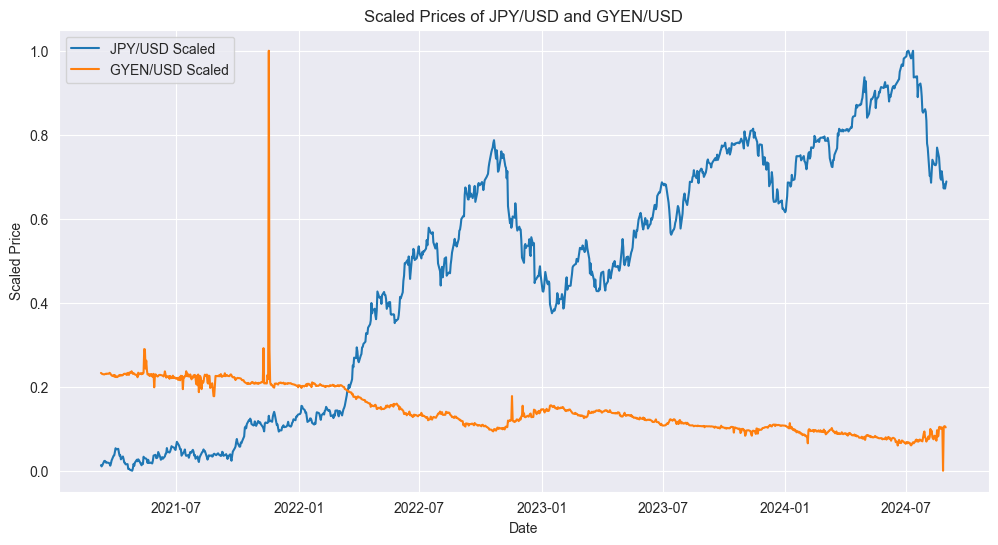

In [6]:
import matplotlib.pyplot as plt

# Plot JPY and GYEN price data
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Close_scaled'], label='JPY/USD Scaled')
plt.plot(gyen_usd.index, gyen_usd['Close_scaled'], label='GYEN/USD Scaled')
plt.title('Scaled Prices of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

## 2. Rolling Volatility Plot

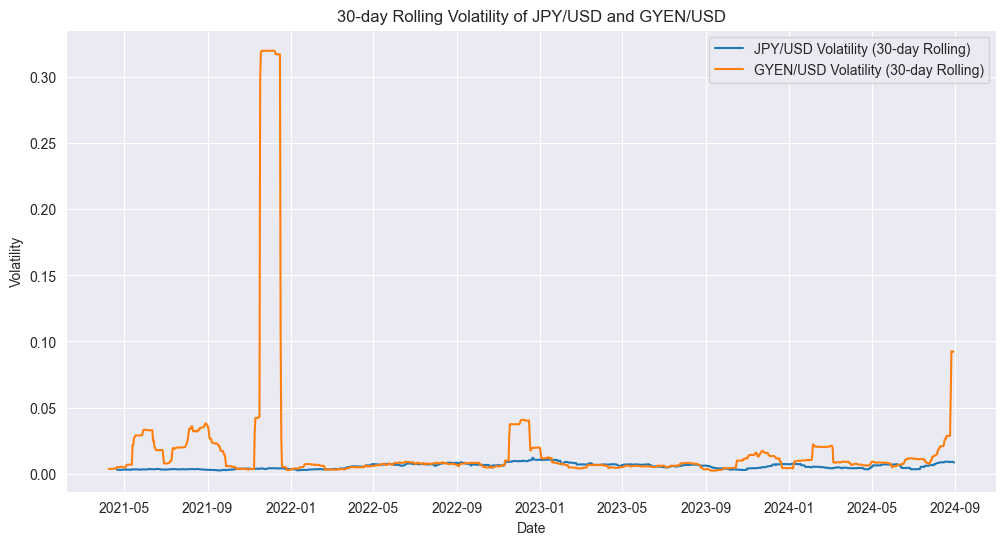

In [8]:
# Calculate rolling volatility (30-day rolling window)
jpy_usd['Rolling_Volatility'] = jpy_usd['Close'].pct_change().rolling(window=30).std()
gyen_usd['Rolling_Volatility'] = gyen_usd['Close'].pct_change().rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Rolling_Volatility'], label='JPY/USD Volatility (30-day Rolling)')
plt.plot(gyen_usd.index, gyen_usd['Rolling_Volatility'], label='GYEN/USD Volatility (30-day Rolling)')
plt.title('30-day Rolling Volatility of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()